#Run cross-group analyses that lyman doesn't suppport

In [1]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import ImageMeants
from nipype.interfaces.fsl import ImageStats

%matplotlib inline

In [4]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
exps = ['sim','ser']
runs = map(str,range(1,4))

In [64]:
#Make design file for paired t-test
num_subs = len(sub_list)
group_dir = home_dir + 'analysis/group_ser_sim/'

##make regressor and contrast inputs according to FSL rules for paired ttest
regressors = dict(diff = list(np.hstack([np.ones(num_subs)*1.0,np.ones(num_subs)-2.0])))
for i in range(num_subs):
    col = np.zeros(num_subs*2)
    col[i] = 1.0
    col[i + num_subs] = 1.0
    regressors['sub' + str(i)] = list(col)
    
# contrasts=[['ser-sim','T',['diff'],[1]], ['sim-ser','T',['diff'],[-1]]]
contrasts=[['ser-sim','T',['diff'],[1]]]

##set up WF so I can control where outputs go
# model = Node(fsl.MultipleRegressDesign(regressors = regressors, contrasts = contrasts),name='model')

#for randomise, we need groups for exchangability blocks
group = list(np.hstack([np.arange(num_subs)+1,np.arange(num_subs)+1]))
model = Node(fsl.MultipleRegressDesign(regressors = regressors, 
                                       contrasts = contrasts, groups = group),name='model')


wf = Workflow(name = 'design',base_dir = group_dir)
sink = Node(DataSink(),name = 'sinker',base_directory = group_dir)
wf.connect(model,'design_con',sink,'output.@con')
wf.connect(model,'design_grp',sink,'output.@grp')
wf.connect(model,'design_mat',sink,'output.@mat')
wf.run()

INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running serially.
INFO:workflow:Executing node model in dir: /data/home/iballard/fd/analysis/group_ser_sim/design/model
INFO:workflow:Executing node sinker in dir: /data/home/iballard/fd/analysis/group_ser_sim/design/sinker


In [39]:
#alternatively, make correlation design file
num_subs = len(sub_list)

group_dir = home_dir + 'analysis/ser_correlation/'
cov = np.loadtxt(home_dir + '/analysis/omegas.txt')

##make regressor and contrast inputs according to FSL rules for paired ttest
regressors = dict(mean = list(np.ones(num_subs)*1.0), cov = list(cov) )
contrasts=[['ser-corr','T',['cov'],[1]]]

##set up WF so I can control where outputs go
model = Node(fsl.MultipleRegressDesign(regressors = regressors, contrasts = contrasts),name='model')
wf = Workflow(name = 'design',base_dir = group_dir)
sink = Node(DataSink(),name = 'sinker',base_directory = group_dir)
wf.connect(model,'design_con',sink,'output.@con')
wf.connect(model,'design_grp',sink,'output.@grp')
wf.connect(model,'design_mat',sink,'output.@mat')
wf.run()

INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running serially.
INFO:workflow:Executing node model in dir: /data/home/iballard/fd/analysis/ser_correlation/design/model
INFO:workflow:Executing node sinker in dir: /data/home/iballard/fd/analysis/ser_correlation/design/sinker


In [55]:
#merge the 3d files from ffx analysis into concatenated 4d files
images = ['cope','varcope','dof','zstat']
ims_to_files = {'cope':'cope1.nii.gz', 'varcope':'varcope1.nii.gz',
                'dof':'tdof_t1.nii.gz','zstat':'zstat1.nii.gz'}
contrast = 'state'
for f in images:
    out_dir = group_dir + contrast
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    
    #add files to merge command
    out_f = out_dir + '/' + f + '_merged.nii.gz'
    if not os.path.exists(out_f):
        cmd_str = ['fslmerge','-t',out_f]

        for exp in ['ser','sim']: #order matters now
            for sub in sub_list:
                sub_f = home_dir + '/analysis/' + exp + '_8mm-PEfb-diff/' + sub + '/ffx/mni/smoothed/' + \
                    contrast + '/' + ims_to_files[f]
                cmd_str.append(sub_f)
        cmd_str = ' '.join(cmd_str)
        os.system(cmd_str)

In [49]:
#merge the 3d files from ffx analysis into concatenated 4d files
images = ['cope','varcope','dof','zstat']
ims_to_files = {'cope':'cope1.nii.gz', 'varcope':'varcope1.nii.gz',
                'dof':'tdof_t1.nii.gz','zstat':'zstat1.nii.gz'}
contrast = 'PE_mb'
for f in images:
    out_dir = group_dir + contrast
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    
    #add files to merge command
    for exp in ['ser','sim']: #order matters now
        out_f = out_dir + '/' + f + '_' + exp + '_merged.nii.gz'
        if not os.path.exists(out_f):
            cmd_str = ['fslmerge','-t',out_f]
            for sub in sub_list:
                sub_f = home_dir + '/analysis/' + exp + '_8mm-PEfb-diff/' + sub + '/ffx/mni/smoothed/' + \
                    contrast + '/' + ims_to_files[f]
                cmd_str.append(sub_f)
        cmd_str = ' '.join(cmd_str)
        os.system(cmd_str)

In [42]:
#Run flameo
wf = Workflow(name = 'flameo',base_dir = group_dir)
exp = 'ser'
#input image files
im_dir = group_dir + contrast
cope_file = im_dir + '/cope_' + exp + '_merged.nii.gz'
var_cope_file = im_dir + '/varcope_' + exp + '_merged.nii.gz'
dof_var_cope_file = im_dir + '/dof_' + exp + '_merged.nii.gz'

#input design files
design_dir = group_dir + '/design/sinker/output/'
t_con_file = design_dir + 'design.con'
cov_split_file = design_dir + 'design.grp'
design_file = design_dir + 'design.mat'

#mask file
mask_file = home_dir + '/analysis/ser_8mm-PEfb-diff/group/mni/' + contrast + '/mask.nii.gz'

#set up flame
flameo = Node(fsl.FLAMEO(cope_file = cope_file, var_cope_file= var_cope_file,
                    dof_var_cope_file = dof_var_cope_file, run_mode = 'flame1',
                   t_con_file = t_con_file, cov_split_file = cov_split_file, 
                    design_file = design_file, mask_file = mask_file), name = 'flameo')

#estimate smoothness
smoothest = Node(fsl.SmoothEstimate(mask_file = mask_file),name='smoothest')
wf.connect(flameo,'zstats',smoothest,'zstat_file')

#set up cluster correction
cluster = Node(fsl.Cluster(threshold = 2.3, pthreshold = 0.05, out_threshold_file = True,
                          out_index_file = True, out_localmax_txt_file=True,
                           peak_distance=30, use_mm=True),name='cluster')
wf.connect(smoothest,'dlh',cluster,'dlh')
wf.connect(smoothest,'volume',cluster,'volume')
wf.connect(flameo,'zstats',cluster,'in_file')

##set up DataSink so I can control where outputs go
sink = Node(DataSink(),name = 'sinker',base_directory = group_dir)
wf.connect(flameo,'copes',sink,'output.copes')
wf.connect(flameo,'fstats',sink,'output.fstats')
wf.connect(flameo,'mrefvars',sink,'output.mrefvars')
wf.connect(flameo,'pes',sink,'output.pes')
wf.connect(flameo,'res4d',sink,'output.res4d')
wf.connect(flameo,'stats_dir',sink,'output.stats_dir')
wf.connect(flameo,'tdof',sink,'output.tdof')
wf.connect(flameo,'tstats',sink,'output.tstats')
wf.connect(flameo,'var_copes',sink,'output.varcopes')
wf.connect(flameo,'weights',sink,'output.weights')
wf.connect(flameo,'zfstats',sink,'output.zfstats')
wf.connect(flameo,'zstats',sink,'output.zstats')

wf.connect(cluster,'index_file',sink,'output.cluster.index_file')
wf.connect(cluster,'localmax_txt_file',sink,'output.cluster.localmax_txt_file')
wf.connect(cluster,'localmax_vol_file',sink,'output.cluster.localmax_vol_file')
wf.connect(cluster,'max_file',sink,'output.cluster.max_file')
wf.connect(cluster,'mean_file',sink,'output.cluster.mean_file')
wf.connect(cluster,'pval_file',sink,'output.cluster.pval_file')
wf.connect(cluster,'size_file',sink,'output.cluster.size_file')
wf.connect(cluster,'threshold_file',sink,'output.cluster.threshold_file')

wf.run()

/usr/lib/python2.7/dist-packages/nipype/interfaces/base.py:397: UserWarning: Input pthreshold requires inputs: dlh, volume
  warn(msg)
INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running serially.
INFO:workflow:Executing node flameo in dir: /data/home/iballard/fd/analysis/ser_correlation/flameo/flameo
INFO:workflow:Running: flameo --copefile=/data/home/iballard/fd/analysis/ser_correlation/PE_mb/cope_ser_merged.nii.gz --covsplitfile=/data/home/iballard/fd/analysis/ser_correlation//design/sinker/output/design.grp --designfile=/data/home/iballard/fd/analysis/ser_correlation//design/sinker/output/design.mat --dofvarcopefile=/data/home/iballard/fd/analysis/ser_correlation/PE_mb/dof_ser_merged.nii.gz --ld=stats --maskfile=/data/home/iballard/fd//analysis/ser_8mm-PEfb-diff/group/mni/PE_mb/mask.nii.gz --runmode=flame1 --tcontrastsfile=/data/home/iballard/fd/analysis/ser_correlation//design/sinker/output/design.con --varcopefile=/data/home/iballard/fd/analysis/ser_correlation/

INFO:workflow:Converting dotfile: /data/home/iballard/fd/analysis/group_ser_sim/flameo/workflow_graph.dot to png format


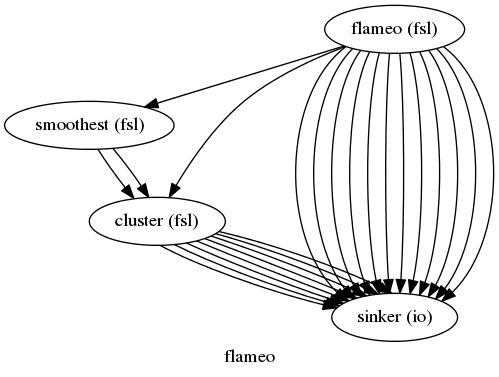

In [8]:
wf.write_graph('workflow_graph.dot')
Image(filename = '/data/home/iballard/fd/analysis/group_ser_sim/flameo/workflow_graph.dot.png' ) 

In [51]:
#do fitting with randomise
#input image files
im_dir = group_dir + contrast
zstat_file = im_dir + '/zstat_' + exp + '_merged.nii.gz'
mask_file = home_dir + '/analysis/ser_8mm-PEfb-diff/group/mni/' + contrast + '/mask.nii.gz'

#input design files
design_dir = group_dir + '/design/sinker/output/'
t_con_file = design_dir + 'design.con'
cov_split_file = design_dir + 'design.grp'
design_file = design_dir + 'design.mat'
cmd_str = ['randomise','-i',zstat_file,'-o',group_dir,'-d',design_file,
           '-t',t_con_file,'-m',mask_file,'-n','500','-D','-T','-1']
cmd_str = ' '.join(cmd_str)
os.system(cmd_str)

0

In [69]:
#do fitting with randomise
#input image files
im_dir = group_dir + contrast
zstat_file = im_dir + '/zstat_merged.nii.gz'
mask_file = home_dir + '/analysis/ser_8mm-PEfb-diff/group/mni/' + contrast + '/mask.nii.gz'

#input design files
design_dir = group_dir + '/design/sinker/output/'
t_con_file = design_dir + 'design.con'
cov_split_file = design_dir + 'design.grp'
design_file = design_dir + 'design.mat'
cmd_str = ['randomise','-i',zstat_file,'-o',group_dir,'-d',design_file,
           '-t',t_con_file,'-m',mask_file,'-e',cov_split_file,'-n','500','-C','1.7']
cmd_str = ' '.join(cmd_str)
os.system(cmd_str)

0